Эксперимент проходил с 2022-10-03 по 2022-10-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 

3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [1]:
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_smoothed_ctr, ab_test_report, bootstrap

In [2]:
connection = {'host': 'http://172.18.0.1:8123', 'database': 'test'}

In [3]:
query = "select value from {db}.ctl_metadata where table='test.feed_actions' and param='timedelta'"
days_shift = int(ph.read_clickhouse(query, connection=connection).min().to_list()[0])

period_old = ['2022-10-03', '2022-10-09']
period_new = [(dt.strptime(d, '%Y-%m-%d')+td(days=days_shift)).strftime('%Y-%m-%d') for d in period_old]

In [4]:
# Loading data for groups A and B
query = '''
    select
        exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from test.feed_actions 
    where exp_group in(1, 2) and toDate(time) between '{}' and '{}'
    group by exp_group, user_id
'''.format(*period_new)

feed_actions_df = ph.read_clickhouse(query, connection=connection)
feed_actions_df.head(5)

,exp_group,user_id,likes,views,ctr
0,2,131914,48,158,0.303797
1,1,116668,4,36,0.111111
2,1,120333,9,29,0.310345
3,1,32324,9,25,0.360000
4,2,129294,4,39,0.102564


In [5]:
print('Number of unique values in groups', end='\n\n')
feed_actions_df.groupby('exp_group', as_index = False).agg({'user_id': 'count'})

Number of unique values in groups



,exp_group,user_id
0,1,10079
1,2,9952


In [6]:
global_ctr_a = feed_actions_df[feed_actions_df['exp_group']==1]['likes'].sum() / \
               feed_actions_df[feed_actions_df['exp_group']==1]['views'].sum()
global_ctr_b = feed_actions_df[feed_actions_df['exp_group']==2]['likes'].sum() / \
               feed_actions_df[feed_actions_df['exp_group']==2]['views'].sum()

feed_actions_df.loc[feed_actions_df['exp_group']==1, 'smoothed_ctr'] = \
    feed_actions_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_a, 5), axis=1)
feed_actions_df.loc[feed_actions_df['exp_group']==2, 'smoothed_ctr'] = \
    feed_actions_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_b, 5), axis=1)

In [7]:
group_a = feed_actions_df[feed_actions_df['exp_group']==1]
group_b = feed_actions_df[feed_actions_df['exp_group']==2]

In [8]:
mean_ctr_a = group_a.ctr.mean()
mean_ctr_b = group_b.ctr.mean()

print("{}Control group{}Test group".format(' '*12, ' '*10))
print("Mean CTR:   {:>1.4f}{:>23}".format(np.round(mean_ctr_a, 4), np.round(mean_ctr_b, 4)))
print("Global CTR: {:>1.4f}{:>23}".format(np.round(global_ctr_a, 4), np.round(global_ctr_b, 4)))

            Control group          Test group
Mean CTR:   0.2156                 0.2144
Global CTR: 0.2080                 0.1981


## Comparison of initial groups

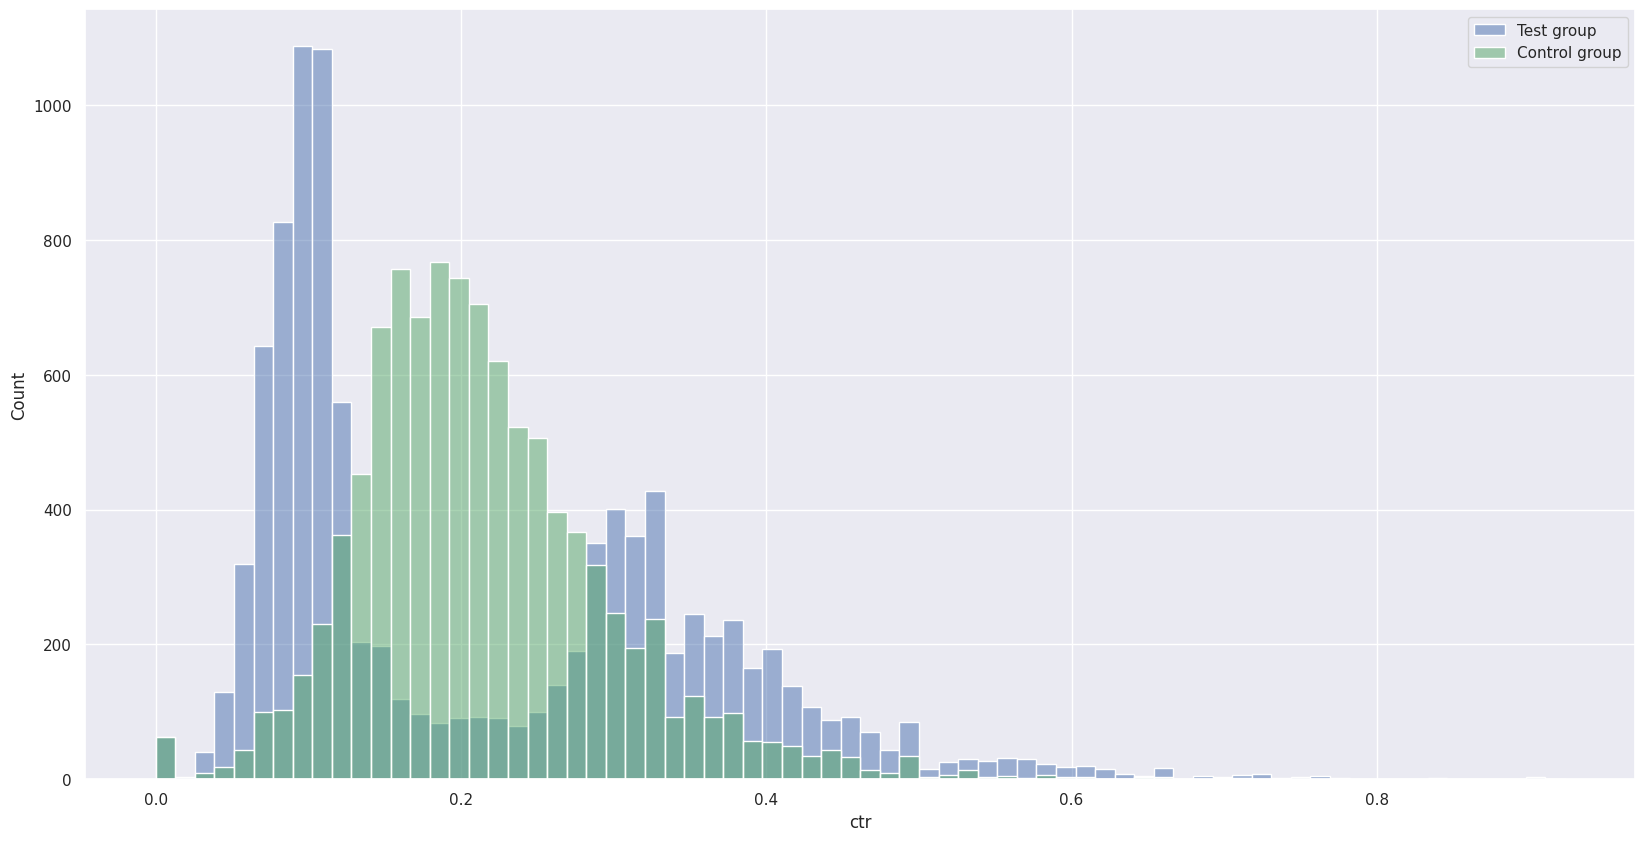

In [9]:
# Plot a histogram for CTR
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_df, x='ctr', hue='exp_group', palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

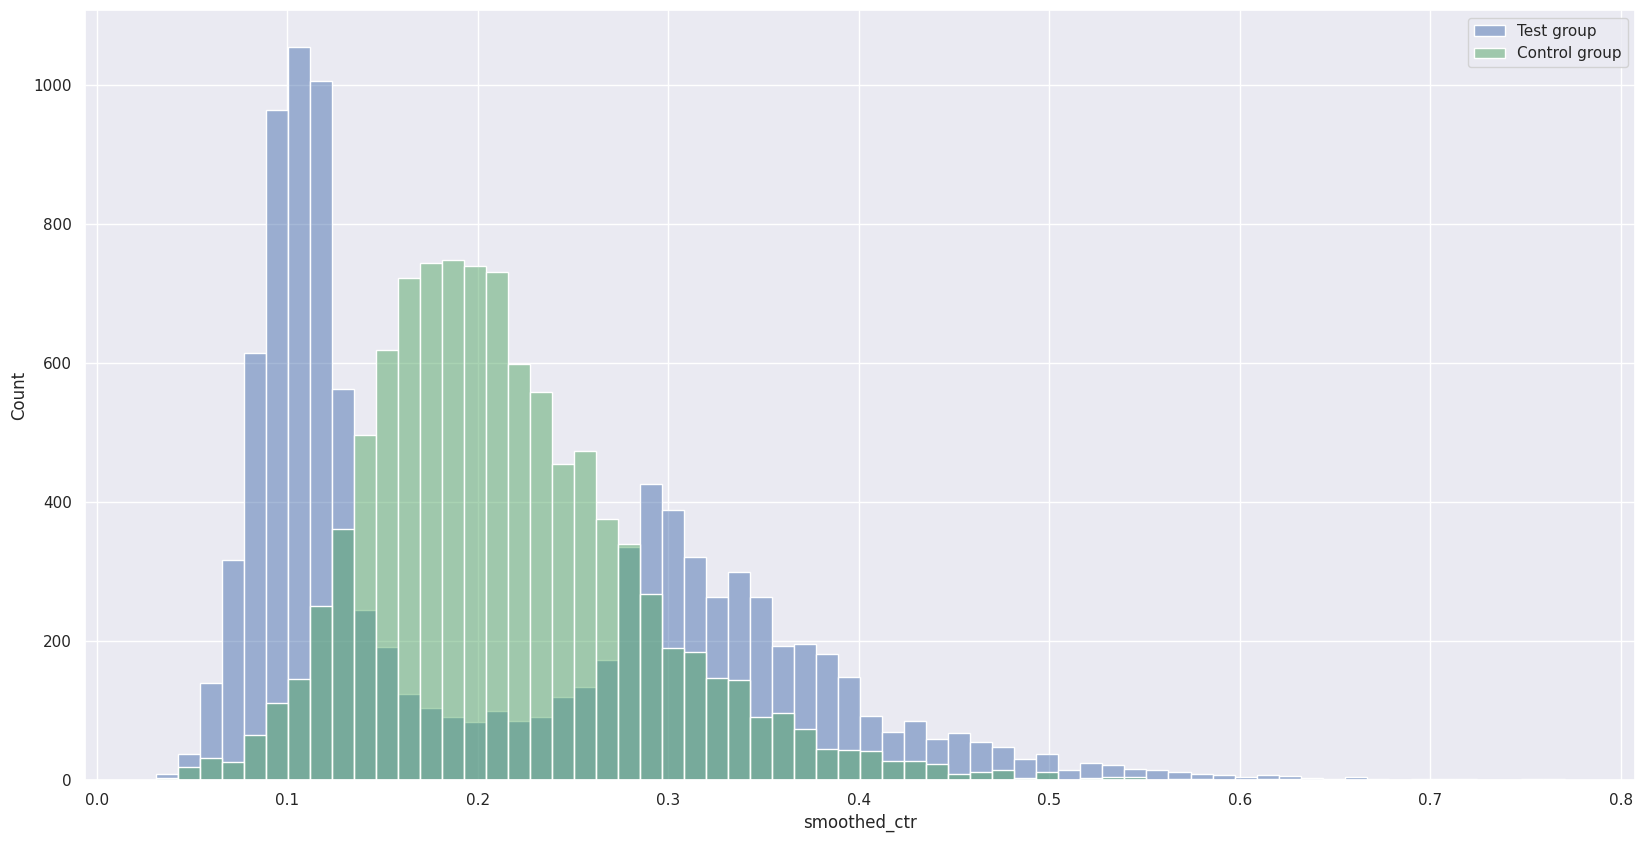

In [10]:
# Plot a histogram for smoothed CTR
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_df, x='smoothed_ctr', hue='exp_group', palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

In [11]:
ab_test_report(group_a, group_b, metrics=['ctr', 'smoothed_ctr'], ttest={'equal_var': False})

ctr               smoothed_ctr              
              ttest  mannwhitneyu        ttest  mannwhitneyu
statistic  0.705164  5.659997e+07     2.279138  5.692356e+07
pvalue     0.480718  6.346628e-56     0.022672  1.722534e-61

## Bootstrap comparison

In [ ]:
N_BOOTS = 5000

boot_ctr = bootstrap(group_a.likes.to_numpy(), group_a.views.to_numpy(),
                     group_b.likes.to_numpy(), group_b.views.to_numpy(),
                     N_BOOTS)

In [ ]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.histplot(boot_ctr[0], color='g')
sns.histplot(boot_ctr[1], color='b')
_ = plt.legend(labels=['Control group', 'Test group'])

In [ ]:
boot_diff = (boot_ctr[1]-boot_ctr[0]>0).sum() / N_BOOTS * 100
print("Test group bootstrap CTR is better than control group in {}% of cases".format(boot_diff))

## Buckets comparison

In [ ]:
N_BUCKETS = 50

buckets_df = feed_actions_df.loc[:, ['exp_group', 'user_id', 'likes', 'views']]
buckets_df['bucket'] = pd.util.hash_pandas_object(feed_actions_df.user_id, index=False) % N_BUCKETS
buckets_df = buckets_df.groupby(by=['exp_group', 'bucket']).agg({'likes': 'sum', 'views': 'sum'}) \
                       .reset_index()
buckets_df['ctr'] = buckets_df.likes / buckets_df.views

In [ ]:
ab_test_report(buckets_df[buckets_df.exp_group==1], 
               buckets_df[buckets_df.exp_group==2], 
               ['ctr'], ttest={'equal_var': False})

In [ ]:
# Plot a histogram for CTR
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=buckets_df, x='ctr', hue='exp_group', palette = ['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

In [ ]:
boot_diff = (buckets_df[buckets_df.exp_group==2].ctr.to_numpy()- \
             buckets_df[buckets_df.exp_group==1].ctr.to_numpy()>0
            ).sum() / N_BUCKETS * 100
print("Test group bootstrap CTR is better than control group in {}% of cases".format(boot_diff))

Сравнение CTR тестом Стьюдента говорит о том, что группы А и Б схожи, и их различия в случае верной нулевой гипотезы могут быть получены с большой вероятностью
Результат теста Манна-Уитни показывает, что различия между группами не случайны и, исходя из сравнения распределений групп на гистограмме и сравнений среднего/глобального CTR, имеет более справедливую оценку, чем T-тест

Сравнение бутстрапированных и бакетированных выборок показывает, что в подавляющем большинстве случаев CTR контрольной группы имеет более высокое значение

### Итог
Различия между группами 1 и 2 очень заметны, причем наша метрика(CTR, smothed CTR) показывает худшие результаты на продукте с внесенными изменениями. Примечательно, что если у первой группы распределение CTR унимодальное и относительно близко к нормальному, то распределение CTR группы 2 бимодальное, будто разбито на две группы, сосредоточившиеся у двух мод, которые лежат по разные стороны от средних значений CTR первой группы

Возможные причины ухудшения результата на тестовой группе:
- до сэмплирования пользователи группы 2 уже учавствовали в другом эксперименте, но в рамках предыдущего эксперимента находились в разных группах, из-за чего произошел эффект "памяти", и пользователи теперь уже одной группы отреагировали на нововведения по-разному
- изменения в продукте разделили пользователей на две условные группы - пользователи, для которых нововведения оказались благоприятны и пользователи, для которых нововведения оказались не благоприятны
- на самом деле алгоритм рекомендаций стал работать лучше, но CTR в данном случае оказался не показательной метрикой


### Рекомендация:
Использование нового алгоритма может навредить продукту, поэтому раскатывать его не рекомендуется. Можно попробовать сделать повторное перемешивание второй солью и провести еще один тест, добавив помимо CTR другую метрику, например время нахождения пользователя в ленте, но в таком случае предположение об ожидаемом росте метрик нужно выдвинуть заранее
